<a href="https://colab.research.google.com/github/ouhenio/stylegan3-projector/blob/add-video-download-to-notebook/StyleGAN3%2BInversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown #**Setup libraries and functions** 🏗️🛠️

%pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
%pip install einops ninja
%pip install wget 

import sys
sys.path.append('./stylegan3')

import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import imageio
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
#from google.colab import files
from time import perf_counter
from stylegan3.dnnlib.util import open_url
import wget


device = torch.device('cuda:0')

# Load VGG16 feature detector.
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)
print('Using device:', device, file=sys.stderr)

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return

# Projector

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = -1,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):

    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    if w_avg_samples > 0:
      logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
      z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    else:
      seed = np.random.randint(0, 2**32 - 1)
      z_samples = np.random.RandomState(seed).randn(1, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

def get_perceptual_loss(synth_image, target_features):
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_image = (synth_image + 1) * (255/2)
    if synth_image.shape[2] > 256:
        synth_image = F.interpolate(synth_image, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_image, resize_images=False, return_lpips=True)
    return (target_features - synth_features).square().sum()

def get_target_features(target):
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    return vgg16(target_images, resize_images=False, return_lpips=True)

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
fatal: destination path 'stylegan3' already exists and is not an empty directory.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Using device: cuda:0


In [2]:
#@markdown #**Model selection** 🎭


#@markdown There are 4 pre-trained options to play with:
#@markdown - FFHQ: Trained with human faces.
#@markdown - MetFaces: Trained with paintings/portraits of human faces.
#@markdown - AFHQv2: Trained with animal faces.
#@markdown - Cosplay: Trained by [l4rz](https://twitter.com/l4rz) with cosplayer's faces.
#@markdown - Wikiart: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the Wikiart 1024 dataset.
#@markdown - Landscapes: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the LHQ dataset.


#@markdown **Run this cell again if you change the model**.

#@markdown ---

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'FFHQ' #@param ["FFHQ", "MetFaces", "AFHQv2", "cosplay", "Wikiart", "Landscapes"]

#@markdown ---

model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://archive.org/download/wikiart-1024-stylegan3-t-17.2Mimg/wikiart-1024-stylegan3-t-17.2Mimg.pkl",
    "Landscapes": "https://archive.org/download/lhq-256-stylegan3-t-25Mimg/lhq-256-stylegan3-t-25Mimg.pkl"
}

network_url = model_name[Model]

with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [6]:
#@markdown #**Parameters** ✍️
#@markdown ---
#@markdown `target_image_filename`: URL or an uploaded file

target_image_filename = "12.png"#@param {type:"string"}
steps = 5001#@param {type:"number"}

if target_image_filename.lower().startswith("http"):
  target_image_filename = download_img(target_image_filename)
target_pil = Image.open(target_image_filename).convert('RGB')
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)
target_tensor = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)

/tmp/ipykernel_7309/1653683658.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  target_pil = target_pil.resize((G.img_resolution, G.img_resolution), Image.LANCZOS)


torch.Size([3, 1024, 1024])


  0%|          | 0/5001 [00:00<?, ?it/s]

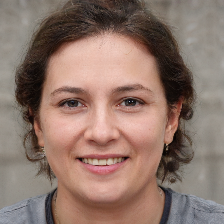

image 0/5001 | loss: 2.015146017074585


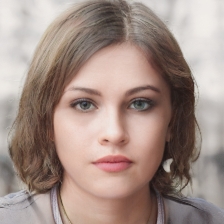

image 100/5001 | loss: 1.0070935487747192


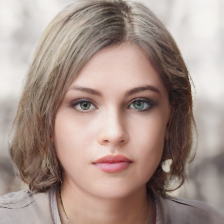

image 200/5001 | loss: 0.8810163140296936


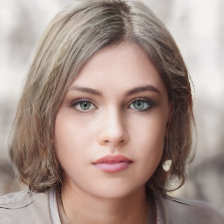

image 300/5001 | loss: 0.8118561506271362


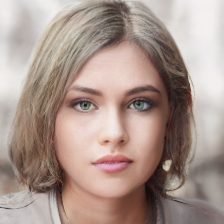

image 400/5001 | loss: 0.8485474586486816


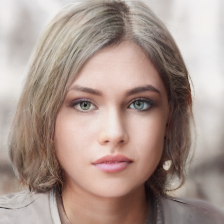

image 500/5001 | loss: 0.7742675542831421


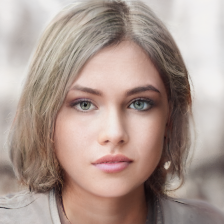

image 600/5001 | loss: 0.7517900466918945


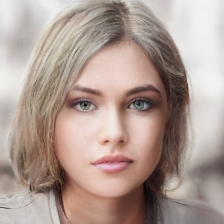

image 700/5001 | loss: 0.7356011867523193


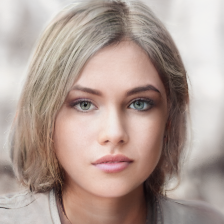

image 800/5001 | loss: 0.7153048515319824


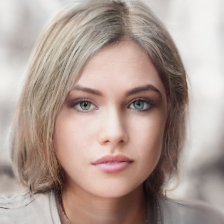

image 900/5001 | loss: 0.8009103536605835


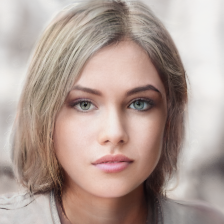

image 1000/5001 | loss: 0.7004122734069824


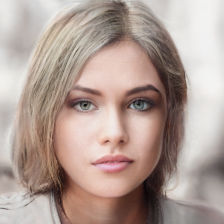

image 1100/5001 | loss: 0.6551876068115234


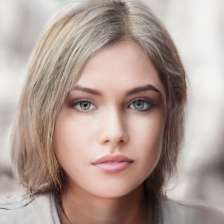

image 1200/5001 | loss: 0.6452784538269043


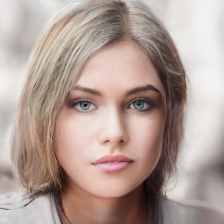

image 1300/5001 | loss: 0.6717895269393921


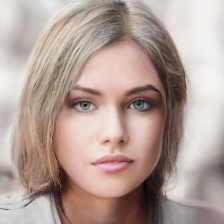

image 1400/5001 | loss: 0.6442908644676208


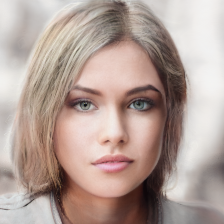

image 1500/5001 | loss: 0.6225671172142029


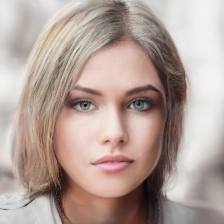

image 1600/5001 | loss: 0.6256613731384277


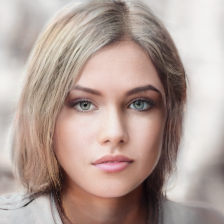

image 1700/5001 | loss: 0.6186671257019043


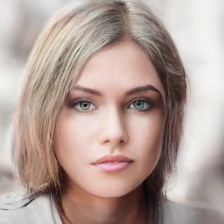

image 1800/5001 | loss: 0.6187400221824646


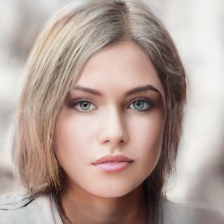

image 1900/5001 | loss: 0.6548136472702026


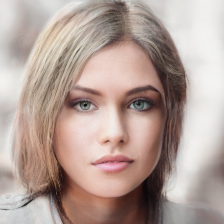

image 2000/5001 | loss: 0.6100374460220337


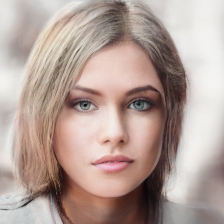

image 2100/5001 | loss: 0.607965350151062


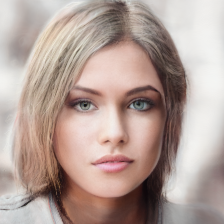

image 2200/5001 | loss: 0.7337112426757812


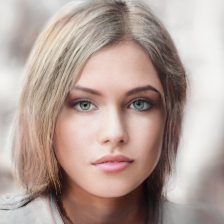

image 2300/5001 | loss: 0.5870572924613953


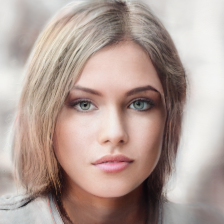

image 2400/5001 | loss: 0.5872745513916016


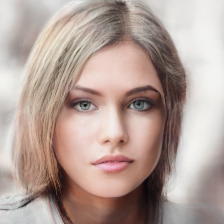

image 2500/5001 | loss: 0.5986921787261963


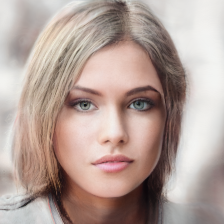

image 2600/5001 | loss: 0.5760184526443481


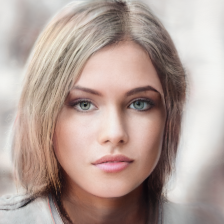

image 2700/5001 | loss: 0.593887448310852


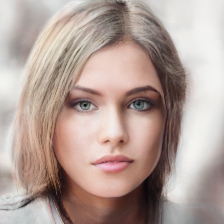

image 2800/5001 | loss: 0.6622095108032227


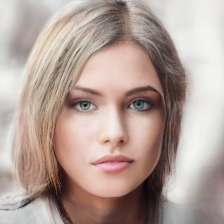

image 2900/5001 | loss: 0.5756389498710632


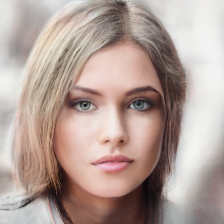

image 3000/5001 | loss: 0.5926163196563721


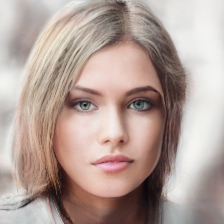

image 3100/5001 | loss: 0.5712820887565613


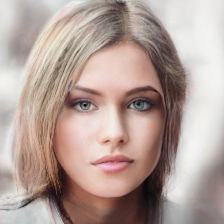

image 3200/5001 | loss: 0.6031959652900696


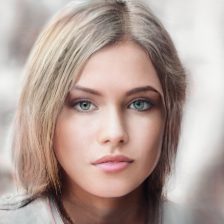

image 3300/5001 | loss: 0.5746399760246277


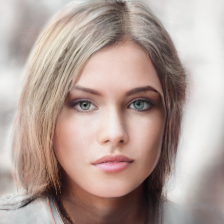

image 3400/5001 | loss: 0.6155992150306702


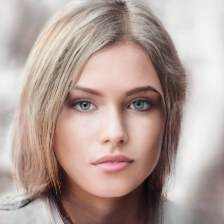

image 3500/5001 | loss: 0.5820525884628296


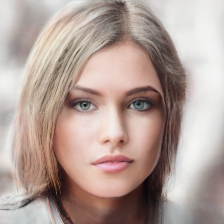

image 3600/5001 | loss: 0.6162758469581604


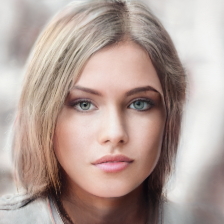

image 3700/5001 | loss: 0.5912413001060486


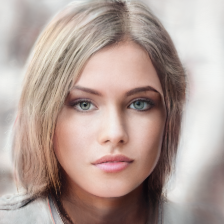

image 3800/5001 | loss: 0.6152828335762024


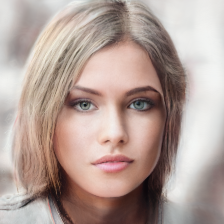

image 3900/5001 | loss: 0.5666370391845703


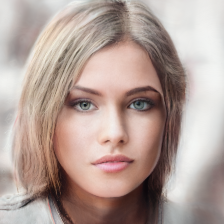

image 4000/5001 | loss: 0.565948486328125


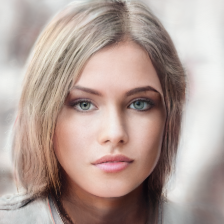

image 4100/5001 | loss: 0.5812475681304932


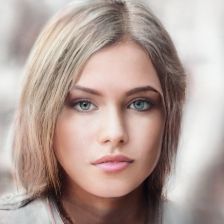

image 4200/5001 | loss: 0.5647574663162231


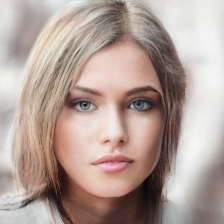

image 4300/5001 | loss: 0.586468517780304


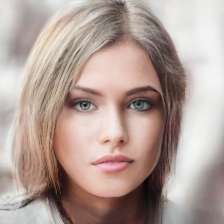

image 4400/5001 | loss: 0.5891512632369995


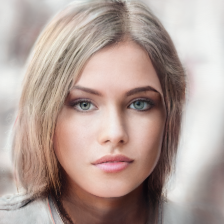

image 4500/5001 | loss: 0.5860310792922974


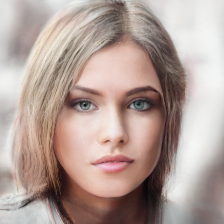

image 4600/5001 | loss: 0.5537362694740295


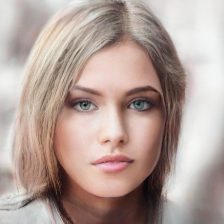

image 4700/5001 | loss: 0.713287889957428


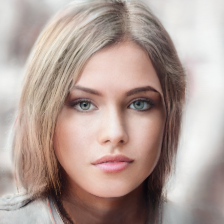

image 4800/5001 | loss: 0.5532726049423218


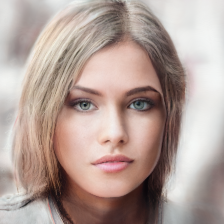

image 4900/5001 | loss: 0.5718706846237183


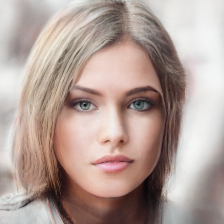

image 5000/5001 | loss: 0.5550714135169983


In [7]:
#@markdown #**Run the inversion** 🚀
import PIL
def resize_image(image):
    newx = 224
    newy = 224
    ishape = np.shape(image)
    ix = ishape[2]
    iy = ishape[3]
    if ix > newx or iy > newy:
        image = F.interpolate(image, size=(newx, newy), mode='area')    
    return image

def calcTargets(coords, image):
    targets = []
    i = 0
    image = image.unsqueeze(0).to(device).to(torch.float32)
    for c in coords:        
        target = resize_image(image[0:1, 0:3, c[0]:c[1], c[2]:c[3]])
        PIL.Image.fromarray(target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy(), 'RGB').save(f'proj{i}.jpg')
        targets.append(vgg16(target, resize_images=False, return_lpips=True))
        i += 1
    return targets

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

seed = 15

def run(timestring, projection_target):
  torch.manual_seed(seed)

  target_features = get_target_features(projection_target)
  print(np.shape(projection_target))
  mouthp = [512, 722]
  eyeleftp = [412, 512]
  eyerightp = [612, 512]
  minx = 0
  maxx = 1024
  miny = 0
  maxy = 1024
  canvas1 = [0, 512, 0, 512] #y_start,y_end,x_start,x_end
  canvas2 = [512, 1024, 0, 512] #y_start,y_end,x_start,x_end
  canvas3 = [0, 512, 512, 1024] #y_start,y_end,x_start,x_end
  canvas4 = [512, 1024, 512, 1024] #y_start,y_end,x_start,x_end
  canvas = [0, 1024, 0, 1024] #y_start,y_end,x_start,x_end
  mouth = [max(mouthp[1]-140,miny), min(mouthp[1]+80,maxy), max(mouthp[0]-110,minx), min(mouthp[0]+110,maxx)]
  left_eye = [max(eyeleftp[1]-80,miny), min(eyeleftp[1]+20,maxy), max(eyeleftp[0]-120,minx), min(eyeleftp[0]+60,maxx)]
  right_eye = [max(eyerightp[1]-80,miny), min(eyerightp[1]+20,maxy), max(eyerightp[0]-60,minx), min(eyerightp[0]+120,maxx)]  
  #coords = [canvas1, canvas2, canvas3, canvas4, mouth, left_eye, right_eye]
  coords = [canvas, mouth, left_eye, right_eye]
  fweights = [1.0, 1.0, 1.0, 1.0]
  #coords = [canvas]
  #fweights = [1]
  targets = calcTargets(coords, projection_target)
  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(1):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.0001) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      dist = 0
      for (c, target, fweight) in zip(coords, targets, fweights):
          synth_image_clone = images.clone()
          synth_image_clone = (synth_image_clone + 1) * (255/2)
          #synth_image_clone = torch.mul(synth_image_clone, torch_mask)
          synth = resize_image(synth_image_clone[0:4, 0:3, c[0]:c[1], c[2]:c[3]])
          #PIL.Image.fromarray(synth.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy(), 'RGB').save(f'proj.jpg')
          synth_features = vgg16(synth, resize_images=False, return_lpips=True)
          dist += (target - synth_features).square().sum() #* fweight
      loss = dist
      #loss += q.square().sum() * 0.0001
      #loss = get_perceptual_loss(images, target_features)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss)
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.02, betas=(0.9,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')    
    dist = 0
    for (c, target, fweight) in zip(coords, targets, fweights):
      synth_image_clone = image.clone()
      synth_image_clone = (synth_image_clone + 1) * (255/2)
      #synth_image_clone = torch.mul(synth_image_clone, torch_mask)
      synth = resize_image(synth_image_clone[0:4, 0:3, c[0]:c[1], c[2]:c[3]])
      #if i % 200 == 0:
        #PIL.Image.fromarray(synth.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy(), 'RGB').save(f'proj{i}.jpg')
      synth_features = vgg16(synth, resize_images=False, return_lpips=True)
      dist += (target - synth_features).square().sum() #* fweight
    loss = dist
    #loss = get_perceptual_loss(image, target_features)
    loss += q.square().sum() * 0.00003
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 100 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"image {i}/{steps} | loss: {loss}")
    #pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    #os.makedirs(f'samples/{timestring}', exist_ok=True)
    #pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring, target_tensor)
except KeyboardInterrupt:
  pass

In [ ]:
#@markdown #**Generate video** 🎥

#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length = 14 #@param {type:"number"}
#Video filename
video_name = "" #@param {type:"string"}
video_name = slugify(video_name)

if not video_name:
  video_name = "video"
# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

print("Generating video...")
!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is ready")

In [ ]:
#@markdown #**Download video** 📀

#Video filename

files.download(f"samples/{video_name}.mp4")